The watershed data are located in:
`/data/projects/AR_Science/CIROH/QPE/PRISM/HUC8/hucdata/ABCDEFGH.txt`

where ABCDEFGH correspond to the HUC8 ID of the watersheds. The data I have aggregated in each file are daily from 1 Jan 2000 to 31 Dec 2019. It's the 24-hour precip ending at 1200 UTC on that day. Units are mean areal precipitation in mm. 

Mean areal precipitation is calculated by identifying the lat/lon pairs on a 0.05-degree grid that fall in each watershed. Interpolating the PRISM 4-km grid to those points in the watershed using bilinear interpolation then taking the average. 

The best way to identify your watersheds is to look at a HUC8 ID map, shape file, or query the online page: https://cw3e.ucsd.edu/Projects/QPF/QPF-HUC8.html

The 4-km gridded precip organized by date used to derive the above climatology is located in `/data/projects/AR_Science/CIROH/QPE/PRISM/1981-2021/` and has additional years.

In [1]:
import sys
import glob
import re

import geopandas as gpd
import cartopy
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import cmocean.cm as cmo

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

In [2]:
path_to_data = '/data/projects/Comet/cwp140/' 
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## use geopandas to import the shapefile
fp = path_to_data + 'downloads/CO_HUC8/wbdhu8.shp'
polys = gpd.read_file(fp, crs="epsg:4326") # have to manually set the projection

In [54]:
idx = polys["Name"] == 'Middle South Platte-Sterling'
tmp = polys.loc[idx]

In [55]:
tmp

,OBJECTID,TNMID,MetaSource,SourceData,SourceOrig,SourceFeat,LoadDate,GNIS_ID,AreaAcres,AreaSqKm,States,HUC8,Name,Shape_Leng,Shape_Area,geometry
44,45,{2C85396F-982B-47E5-BD35-125F2394511A},None,None,None,None,2012-06-11,0,"1,909,004.83","7,725.48","CO,NE",10190012,Middle South Platte-Sterling,9.68,0.82,"POLYGON ((-102.56444 41.07426, -102.56426 41.0..."


<AxesSubplot:>

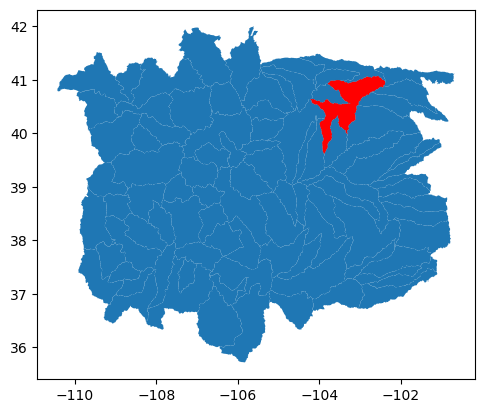

In [56]:
## create a list of HUC8 watersheds we are interested in
## https://www.arcgis.com/apps/mapviewer/index.html?panel=gallery&suggestField=true&layers=72d8dd97a0b44a4b8101f39a79792bca


fig, ax = plt.subplots() # initiates a figure
polys.plot(ax=ax); # plots all lines
tmp.plot(ax=ax, color='red')

In [6]:
polys["Name"].values


array(['Mancos', 'Middle San Juan', 'Lower Gunnison', 'Upper Gunnison',
       'Lower Yampa', 'Conejos', 'Upper Arkansas', 'Huerfano',
       'Canadian Headwaters', 'Horse', 'Bijou', 'Rush', 'Upper Cimarron',
       'Beaver', 'Pawnee', 'Arikaree', 'Frenchman', 'Lower South Platte',
       'Vermilion', 'Colorado Headwaters-Plateau', 'Upper Yampa',
       'Rio Chama', 'St. Vrain', 'Sidney Draw', 'Stinking Water',
       'Upper Colorado-Kane Springs', 'Lower Dolores', 'Little Snake',
       'Fountain', 'Crow', 'Upper Lodgepole',
       'Middle South Platte-Cherry Creek', 'Cimarron Headwaters',
       'Smoky Hill Headwaters', 'McElmo', 'Lower Green-Diamond',
       'Upper Green-Flaming Gorge Reservoir', 'Lower White', 'Piedra',
       'Alamosa-Trinchera', 'Upper Arkansas-Lake Meredith', 'Purgatoire',
       'Colorado Headwaters', 'Kiowa', 'Middle South Platte-Sterling',
       'Bear', 'North Fork Republican', 'South Fork Beaver', 'Saguache',
       'Arkansas Headwaters', 'Roaring Fork', 'E

<AxesSubplot:>

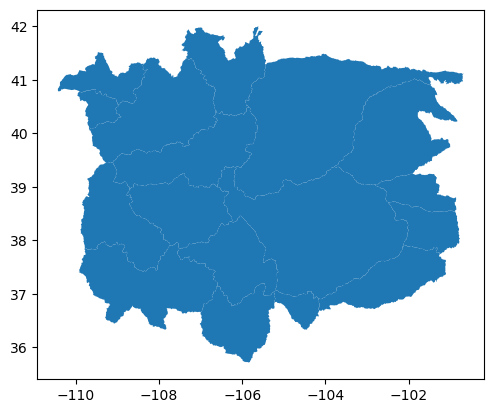

In [15]:
HUC4_lst = []
for i in range(len(polys)):
    HUC4 = polys['HUC8'][i][:4]
    HUC4_lst.append(HUC4)
    
polys['HUC4'] = HUC4_lst

zones = polys.dissolve(by='HUC4')
zones.plot()

In [4]:
centroids = polys.geometry.to_crs('+proj=cea').centroid.to_crs(polys.geometry.crs)
lats = centroids.geometry.y.values
lons = centroids.geometry.x.values

In [5]:
## list of all CO HUC8's
CO_HUC8_lst = polys['HUC8']
CO_HUC8_lst

0     14080107
1     14080105
2     14020005
3     14020002
4     14050002
        ...   
87    10190002
88    11020013
89    11030002
90    11030001
91    10250013
Name: HUC8, Length: 92, dtype: object

In [6]:
## list of Jay's HUC8's
path_to_PRISM = '/data/projects/AR_Science/CIROH/QPE/PRISM/HUC8/hucdata/*.txt'

## find the most recent file in the currect directory
list_of_files = glob.glob(path_to_PRISM)

HUC8_lst = []
# pull the HUC8 from the filename
for i, file in enumerate(list_of_files):
    regex = re.compile(r'\d+')
    HUC8 = regex.findall(file)
    HUC8_lst.append(HUC8[1])

In [7]:
df1 = {'HUC8': CO_HUC8_lst.values}
df2 = {'HUC8': HUC8_lst}
d1 = pd.DataFrame(df1) 
d2 = pd.DataFrame(df2)  
  
# Calling merge() function 
int_df = pd.merge(d1, d2, how='inner', on=['HUC8']) 
print(int_df)

        HUC8
0   14080107
1   14080105
2   14020005
3   14020002
4   14050002
..       ...
87  10190002
88  11020013
89  11030002
90  11030001
91  10250013

[92 rows x 1 columns]


In [8]:
def read_HUC8_PRISM_prec(HUC_ID):
    fname = '/data/projects/AR_Science/CIROH/QPE/PRISM/HUC8/hucdata/{0}.txt'.format(HUC_ID)
    df = pd.read_csv(fname, header=None, names=['date', 'prec'], engine='python')
    df.index = pd.to_datetime(df['date'], format="%Y%m%d")
    df = df.drop(['date'], axis=1)
    
    ## select dates where SWE is > 0.1 inches/2.54 mm
    idx = (df['prec'] > 2.54)
    tmp = df.loc[idx]
    
    ## calculate the 90th percentile of precipitation
    prec_thres = tmp['prec'].describe(percentiles=[.90]).loc['90%'] # 90th percentile precipitation threshold

    ## select rows where precipitation exceeds 90th percentile
    df['extreme'] = (df['prec'] >= prec_thres)
    # create a new var called "extreme" that is 1 if prec exceeds 90th percentile and 0 if not
    df['extreme'] = df['extreme'].astype(int) 

    # convert to xarray
    ds = df.to_xarray()

    return ds

In [9]:
ds_lst = []
for i, HUC_ID in enumerate(int_df.HUC8):
    ## read and preprocess prec data
    ds = read_HUC8_PRISM_prec(HUC_ID)
    ds_lst.append(ds)

In [10]:
## single netcdf with HUC8 ID as coord, prec as var, extreme event as bool var
final_ds = xr.concat(ds_lst, pd.Index(int_df.HUC8.values, name="HUC8"))
final_ds['lat']=(['HUC8'],  lats)
final_ds['lon']=(['HUC8'],  lons)

final_ds

<xarray.Dataset>
Dimensions:  (date: 7305, HUC8: 92)
Coordinates:
  * date     (date) datetime64[ns] 2000-01-01 2000-01-02 ... 2019-12-31
  * HUC8     (HUC8) object '14080107' '14080105' ... '11030001' '10250013'
Data variables:
    prec     (HUC8, date) float64 1.395 10.56 3.702 ... 1.942 0.7039 0.04992
    extreme  (HUC8, date) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    lat      (HUC8) float64 37.18 36.86 38.77 38.38 ... 37.6 38.48 38.08 39.65
    lon      (HUC8) float64 -108.5 -108.6 -108.3 -107.3 ... -101.7 -101.4 -101.6

In [27]:
nevents = []
for i, HUC in enumerate(range(final_ds.prec.shape[0])):
    ds = final_ds.isel(HUC8=HUC)
    ds = ds.where(ds.extreme == 1, drop=True)
    nevents.append(len(ds.prec))
    
sum(nevents)

9556

In [28]:
## save file
fname = path_to_data + 'preprocessed/PRISM/PRISM_HUC8_CO.nc'
final_ds.to_netcdf(path=fname, mode = 'w', format='NETCDF4')

### Get list of unique dates where precip > 90th percentile in all watersheds

In [ ]:
fname = path_to_data + 'preprocessed/PRISM/PRISM_HUC8_CO.nc'
ds = xr.open_dataset(fname)
# get list of event dates for all HUC8s
HUC8_lst = ds.HUC8.values
event_lst = []
for i, HUC8_ID in enumerate(HUC8_lst):
    tmp = ds.sel(HUC8=HUC8_ID)
    tmp = tmp.where(tmp.extreme == 1, drop=True)
    event_dates = tmp.date.values
    event_lst.append(event_dates)

test = np.concatenate(event_lst, axis=0)
len(test)

unique_dates = np.unique(test)
unique_dates
dates = pd.to_datetime(unique_dates)

d = {'date': dates}
df = pd.DataFrame(data=d)
df.to_csv('../out/PRISM_CO_Watershed_90th_percentile_precip_dates.csv')